In [16]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

import scipy
import scipy.cluster.hierarchy as sch
import collections
import operator

sns.set_style('whitegrid')

# Load the data (Music)

In [17]:
# df_tags = pd.read_csv('data/hetrec2011-lastfm-2k/tags.dat', sep='\t', encoding='latin-1')
# df_tags.columns = ['id', 'value']
# print(df_tags.head())

# df_item = pd.read_csv('data/hetrec2011-lastfm-2k/artists.dat', sep='\t', encoding='latin-1')
# df_item = df_item[['id', 'name']]
# df_item.columns = ['id', 'title']
# print(df_item.head())

# df_tag_item = pd.read_csv('data/hetrec2011-lastfm-2k/user_taggedartists.dat', sep='\t')
# df_tag_item = df_tag_item[['artistID', 'tagID']]
# df_tag_item.columns = ['itemID', 'tagID']
# print(df_tag_item.head())

# Load the data (Movies)

In [18]:
df_tags = pd.read_csv('data/hetrec2011-movielens-2k-v2/tags.dat', sep='\t', encoding='latin-1')
df_tags.columns = ['id', 'value']
print(df_tags.head())

df_item = pd.read_csv('data/hetrec2011-movielens-2k-v2/movies.dat', sep='\t', encoding='latin-1')
df_item = df_item[['id', 'title']]
print(df_item.head())

df_tag_item = pd.read_csv('data/hetrec2011-movielens-2k-v2/movie_tags.dat', sep='\t')
df_tag_item = df_tag_item[['movieID', 'tagID']]
df_tag_item.columns = ['itemID', 'tagID']
print(df_tag_item.head())

   id    value
0   1    earth
1   2   police
2   3   boxing
3   4  painter
4   5    whale
   id                        title
0   1                    Toy story
1   2                      Jumanji
2   3               Grumpy Old Men
3   4            Waiting to Exhale
4   5  Father of the Bride Part II
   itemID  tagID
0       1      7
1       1     13
2       1     25
3       1     55
4       1     60


In [19]:
# merging the files
df_merge = df_tag_item.merge(df_tags, how='left', left_on='tagID', right_on='id')
df_merge = df_merge.merge(df_item, how='left', left_on='itemID', right_on='id')
df_merge.head()

,itemID,tagID,id_x,value,id_y,title
0,1,7,7,funny,1,Toy story
1,1,13,13,time travel,1,Toy story
2,1,25,25,tim allen,1,Toy story
3,1,55,55,comedy,1,Toy story
4,1,60,60,fun,1,Toy story


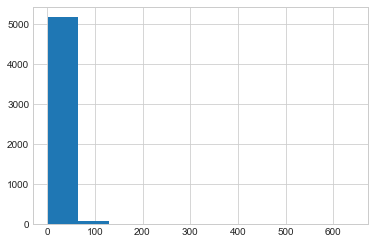

In [20]:
# Distribution of the count of tags
plt.hist(df_merge['value'].value_counts(), bins=10)
plt.show()

In [21]:
# most common tags
df_counts = df_merge['value'].value_counts().reset_index()
print(len(df_counts))
df_counts.columns = ['tag', 'count']
df_counts = df_counts[df_counts['count']>10]
print(len(df_counts))
df_counts.head()

5297
956


,tag,count
0,tumeys dvds,640
1,less than 300 ratings,491
2,erlends dvds,403
3,70mm,370
4,based on a book,369


In [22]:
# pivot the dataframe
df_pivot = df_merge[df_merge['value'].isin(df_counts['tag'])].pivot_table(index='itemID', columns='value', aggfunc=len).fillna(0.0)['tagID']

In [23]:
# compute the intersection
intersection = {}
for k, v in df_pivot.iterrows():
    tags = v[v>0].index
    for i in range(len(tags)):
        for j in range(i+1, len(tags)):
            if tags[i] not in intersection:
                intersection[tags[i]] = {}
            if tags[j] not in intersection:
                intersection[tags[j]] = {}
            if tags[j] not in intersection[tags[i]]:
                intersection[tags[i]][tags[j]] = 0
            if tags[i] not in intersection[tags[j]]:
                intersection[tags[j]][tags[i]] = 0
            intersection[tags[i]][tags[j]] += 1
            intersection[tags[j]][tags[i]] += 1

In [24]:
#tag = df_counts.sample(1)['tag'].values[0]
tag = 'scifi'
#tag = 'time travel'
#tag = 'rock'
#tag = 'heavy metal'
tag_count = df_counts[df_counts['tag']==tag]['count'].values[0]
print(tag, tag_count)

n_candidates = 10

df_results = pd.DataFrame.from_dict(intersection[tag], orient='index').reset_index()
df_results.columns = ['tag', 'intersection']
df_resuts = df_results.merge(df_counts, how='left', on='tag')
df_resuts['union'] = df_resuts['count'] + tag_count - df_results['intersection']
df_resuts['symetric'] = df_resuts['intersection']/df_resuts['union']
df_resuts['assymetric'] = df_resuts['intersection']/tag_count

symetric_tags = list(df_resuts.sort_values('symetric', ascending=False).head(n_candidates)['tag'].values)
assymetric_tags = list(df_resuts.sort_values('assymetric', ascending=False).head(n_candidates)['tag'].values)

print(df_resuts.sort_values('symetric', ascending=False).head(n_candidates))
print(df_resuts.sort_values('assymetric', ascending=False).head(n_candidates))

scifi 90
                   tag  intersection  count  union  symetric  assymetric
31   futuristmoviescom            54    136    172  0.313953    0.600000
108              space            22     54    122  0.180328    0.244444
46                  sf            16     23     97  0.164948    0.177778
30              future            17     32    105  0.161905    0.188889
116             aliens            22     70    138  0.159420    0.244444
85             fantasy            23     79    146  0.157534    0.255556
4             dystopia            19     59    130  0.146154    0.211111
99              robots            15     36    111  0.135135    0.166667
86          far future            13     20     97  0.134021    0.144444
74              action            28    161    223  0.125561    0.311111
                     tag  intersection  count  union  symetric  assymetric
31     futuristmoviescom            54    136    172  0.313953    0.600000
83                   dvd            32

In [25]:
suggestions = df_pivot[df_pivot[tag]>0].index
df_item[df_item['id'].isin(suggestions)].head()

,id,title
28,29,La cité des enfants perdus
31,32,Twelve Monkeys
188,198,Strange Days
198,208,Waterworld
249,260,Star Wars


In [26]:
suggestions = df_pivot[symetric_tags].sum(axis=1).sort_values(ascending=False).head().index
df_item[df_item['id'].isin(suggestions)]

,id,title
249,260,Star Wars
522,541,Blade Runner
1098,1210,Star Wars: Episode VI - Return of the Jedi
2404,2628,Star Wars: Episode I - The Phantom Menace
8813,34405,Serenity


In [27]:
suggestions = df_pivot[assymetric_tags].sum(axis=1).sort_values(ascending=False).head().index
df_item[df_item['id'].isin(suggestions)]

,id,title
249,260,Star Wars
1085,1196,Star Wars: Episode V - The Empire Strikes Back
1098,1210,Star Wars: Episode VI - Return of the Jedi
2350,2571,The Matrix
8731,33493,Star Wars: Episode III - Revenge of the Sith
